In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import pickle
import os

In [2]:
os.getcwd()

'C:\\Users\\shiro'

In [3]:
os.chdir('C:/Users/shiro/OneDrive/Desktop/Final Project OG/Dataset')

In [4]:
df1 = pd.read_excel("FINAL SUBSET_preprocessed_dataOG.xlsx")    
# data = Multitime series data that is initially sorted by week_end_date, store_id, upc

In [5]:
df1.head()

,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,UPC,UNIT_SALES,UNIT_SALES_LOG,PRICE,PRICE_SQRT,BASE_PRICE,...,DISCOUNT_RATE,FEATURE,DISPLAY,PROMOTION_SUPPORT,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM
0,2009-01-14,2009,3,367,1111009477,13,2.564949,1.39,1.178983,1.57,...,0.11465,0,0,UNSUPPORTED,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721
1,2009-01-14,2009,3,367,1111009497,20,2.995732,1.39,1.178983,1.39,...,0.00000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721
2,2009-01-14,2009,3,367,1111009507,14,2.639057,1.38,1.174734,1.38,...,0.00000,0,0,NONE,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721
3,2009-01-14,2009,3,367,1111038078,3,1.098612,2.50,1.581139,2.50,...,0.00000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),15TH & MADISON,VALUE,0,24721
4,2009-01-14,2009,3,367,1111038080,2,0.693147,2.59,1.609348,2.59,...,0.00000,0,0,NONE,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),15TH & MADISON,VALUE,0,24721


In [6]:
# STORE_ID Frequency Encoding
store_id_counts = df1['STORE_ID'].value_counts().to_dict()
store_id_counts = dict(sorted(store_id_counts.items()))
df1.insert(4, 'STORE_ID_COUNT', df1['STORE_ID'].map(store_id_counts))

In [7]:
# UPC Frequency Encoding
upc_counts = df1['UPC'].value_counts().to_dict()
upc_counts = dict(sorted(upc_counts.items()))
df1.insert(6, 'UPC_COUNT', df1['UPC'].map(upc_counts)) 

In [8]:
# Check for STORE_ID with duplicated counts
store_id_counts = df1['STORE_ID'].value_counts()
duplicated_counts = store_id_counts[store_id_counts.duplicated(keep=False)]

if not duplicated_counts.empty:
    print("Stores with the same count:")
    for count in duplicated_counts.index:
        print(f"Store ID: {count}, Count: {store_id_counts[count]}")
else:
    print("No stores have the same count.")

# Total 65274 having same counts (15% of total data)

# Check for UPC with duplicated counts
upc_id_counts = df1['UPC'].value_counts()
duplicated_counts = upc_id_counts[upc_id_counts.duplicated(keep=False)]

if not duplicated_counts.empty:
    print("\nUPC  with the same count:")
    for count in duplicated_counts.index:
        print(f"UPC: {count}, Count: {upc_id_counts[count]}")
else:
    print("No UPC have the same count.")

# all UPC having same counts are under CEREAL category, so assuming that same count might not cause big issue
# 35478 having same UPC (8% of total data)

Stores with the same count:
Store ID: 613, Count: 5596
Store ID: 2277, Count: 5596
Store ID: 28909, Count: 5575
Store ID: 2281, Count: 5575
Store ID: 19265, Count: 5553
Store ID: 623, Count: 5553
Store ID: 23075, Count: 5519
Store ID: 15547, Count: 5519
Store ID: 2495, Count: 5504
Store ID: 13859, Count: 5504
Store ID: 17627, Count: 5504
Store ID: 13827, Count: 5497
Store ID: 11757, Count: 5497
Store ID: 2541, Count: 5238
Store ID: 23067, Count: 5238

UPC  with the same count:
UPC: 1111085345, Count: 11980
UPC: 1600027564, Count: 11980


In [9]:
# Save mapping of STORE_ID to STORE_ID_COUNT and UPC to UPC_COUNT into Excel file
store_id_df = pd.DataFrame(list(store_id_counts.items()), columns=['STORE_ID', 'STORE_ID_COUNT'])
upc_df = pd.DataFrame(list(upc_counts.items()), columns=['UPC', 'UPC_COUNT'])

with pd.ExcelWriter('StoreID UPC Encoding.xlsx', engine='openpyxl') as writer:  
    store_id_df.to_excel(writer, sheet_name='Store', index=False)
    upc_df.to_excel(writer, sheet_name='Product', index=False)

In [10]:
display(store_id_df)
display(upc_df)

,STORE_ID,STORE_ID_COUNT
0,2513,5618
1,24991,5616
2,613,5596
3,2277,5596
4,11993,5594
...,...,...
72,2523,4819
73,11967,4684
74,23055,4353
75,387,4310


,UPC,UPC_COUNT
0,1111009477,11934
1,1111009497,11960
2,1111009507,11290
3,1111038078,11249
4,1111038080,10667
5,1111085319,11959
6,1111085345,11980
7,1111085350,11963
8,1111087395,11648
9,1111087396,11571


In [11]:
encoded_category = pd.get_dummies(df1 ['CATEGORY']).astype(int)
df1 = pd.concat([df1, encoded_category], axis=1)
df1[['WEEK_END_DATE', 'STORE_ID', 'UPC', 'CATEGORY', 'BAG SNACKS', 'COLD CEREAL', 'FROZEN PIZZA', 'ORAL HYGIENE PRODUCTS']].sample(5)

,WEEK_END_DATE,STORE_ID,UPC,CATEGORY,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
396033,2011-11-16,15541,1111085319,COLD CEREAL,0,1,0,0
330630,2011-05-25,15763,7192100337,FROZEN PIZZA,0,0,1,0
285241,2011-02-02,367,1111087395,FROZEN PIZZA,0,0,1,0
9646,2009-02-04,25021,1600027527,COLD CEREAL,0,1,0,0
223381,2010-08-25,12011,1600027528,COLD CEREAL,0,1,0,0


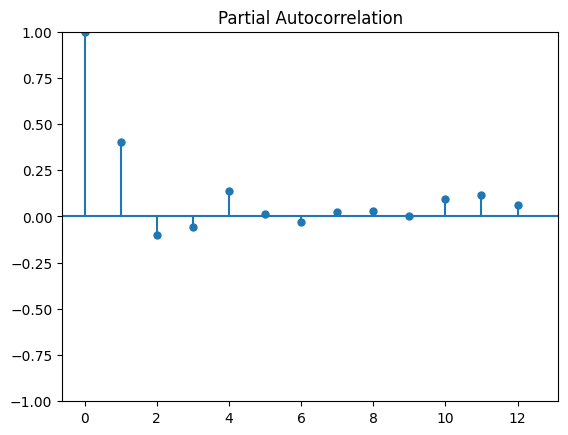

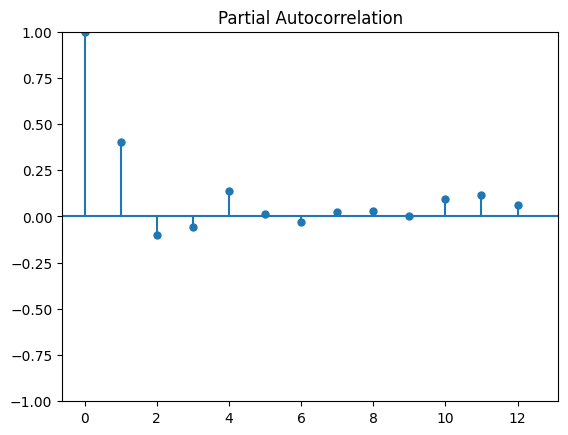

In [12]:
# Partial Autocorrelation Plot shows direct relationships between observations at different time lags. It helps to determine significant lags
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df1["UNIT_SALES_LOG"], lags=12)

In [13]:
print("Before lag features creation: ", df1.shape)

# Group df1 by STORE_ID and UPC so that lag features are shifted by store-product combination.
df1.insert(9, 'UNIT_SALES_LOG_LAG1', df1.groupby(['STORE_ID', 'UPC'])['UNIT_SALES_LOG'].shift(1))
df1.insert(10, 'UNIT_SALES_LOG_LAG2', df1.groupby(['STORE_ID', 'UPC'])['UNIT_SALES_LOG'].shift(2))

# Drop rows (initial periods) with missing values after creating lag features
df1.dropna(inplace=True)
df1.reset_index(inplace = True)
df1.drop(columns=['index'], inplace=True)

print("After lag features creation: ", df1.shape)

Before lag features creation:  (414937, 27)
After lag features creation:  (409247, 29)


In [ ]:
# Check if  UNIT_SALES_LOG_LAG1 and UNIT_SALES_LOG_LAG2 shifted correctly
temp = df1.sort_values(by=['STORE_ID', 'UPC']).head(10)
temp[['WEEK_END_DATE', 'STORE_ID', 'UPC', 'UNIT_SALES_LOG', 'UNIT_SALES_LOG_LAG1', 'UNIT_SALES_LOG_LAG2']]

In [14]:
unique_weeks = pd.DataFrame(df1['WEEK_END_DATE'].unique(), columns=['WEEK_END_DATE'])
print("Total num of weeks: ", len(unique_weeks))

split_index = int(len(unique_weeks) * 0.8)
print("First ",split_index-1, "weeks of data for training")
date_to_split = unique_weeks['WEEK_END_DATE'].iloc[split_index-1]
print("Split at date: ", date_to_split)

train_df = df1[df1['WEEK_END_DATE'] < date_to_split]
test_df = df1[df1['WEEK_END_DATE'] >= date_to_split]

print("\nTrain: ", train_df['WEEK_END_DATE'].min(), "-", train_df['WEEK_END_DATE'].max())
print("Test: ", test_df['WEEK_END_DATE'].min(), "-", test_df['WEEK_END_DATE'].max())

Total num of weeks:  154
First  122 weeks of data for training
Split at date:  2011-06-01 00:00:00

Train:  2009-01-28 00:00:00 - 2011-05-25 00:00:00
Test:  2011-06-01 00:00:00 - 2012-01-04 00:00:00


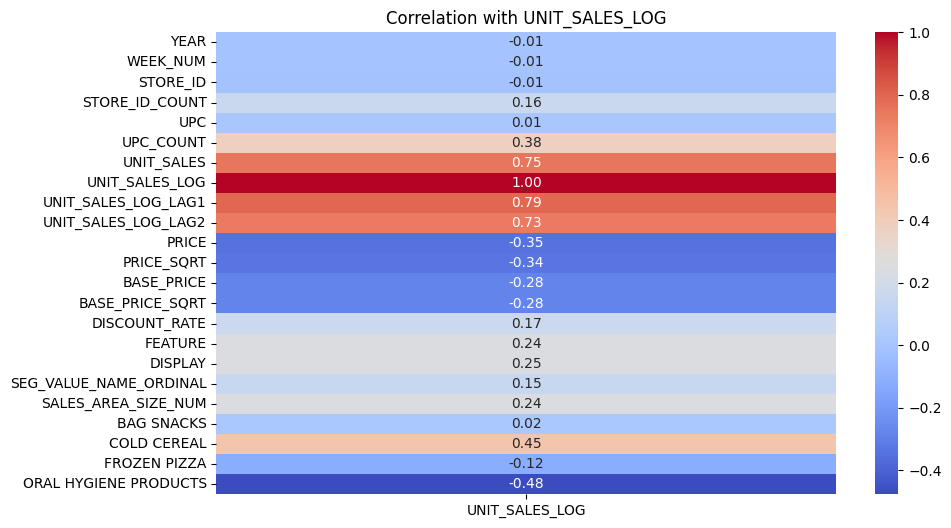

In [15]:
numeric_df = df1.select_dtypes(include=[float, int])

# Plot heatmap for correlation with UNIT_SALES_LOG
plt.figure(figsize=(10, 6))
sbn.heatmap(numeric_df.corr()[['UNIT_SALES_LOG']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with UNIT_SALES_LOG')
plt.show()

In [16]:
# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()

# Print the correlation matrix
print(correlation_matrix)


                            YEAR  WEEK_NUM  STORE_ID  STORE_ID_COUNT  \
YEAR                    1.000000 -0.118594 -0.004043       -0.015407   
WEEK_NUM               -0.118594  1.000000 -0.001766       -0.003432   
STORE_ID               -0.004043 -0.001766  1.000000        0.112977   
STORE_ID_COUNT         -0.015407 -0.003432  0.112977        1.000000   
UPC                     0.054863  0.034100 -0.000495       -0.002578   
UPC_COUNT              -0.004019  0.003803 -0.002154       -0.037630   
UNIT_SALES             -0.005185 -0.007391 -0.002021        0.114842   
UNIT_SALES_LOG         -0.009376 -0.007648 -0.010384        0.160295   
UNIT_SALES_LOG_LAG1    -0.013351  0.002169 -0.010399        0.160411   
UNIT_SALES_LOG_LAG2    -0.007047 -0.008293 -0.010356        0.160533   
PRICE                   0.011332 -0.000068  0.001313        0.001349   
PRICE_SQRT              0.015447  0.000512  0.002113        0.001307   
BASE_PRICE              0.013538 -0.000385  0.002029        0.00

In [17]:
# Display only correlations with UNIT_SALES_LOG
correlation_with_unit_sales_log = correlation_matrix[['UNIT_SALES_LOG']]
print(correlation_with_unit_sales_log)


                        UNIT_SALES_LOG
YEAR                         -0.009376
WEEK_NUM                     -0.007648
STORE_ID                     -0.010384
STORE_ID_COUNT                0.160295
UPC                           0.013945
UPC_COUNT                     0.381248
UNIT_SALES                    0.751023
UNIT_SALES_LOG                1.000000
UNIT_SALES_LOG_LAG1           0.793182
UNIT_SALES_LOG_LAG2           0.729365
PRICE                        -0.346273
PRICE_SQRT                   -0.338154
BASE_PRICE                   -0.283509
BASE_PRICE_SQRT              -0.283666
DISCOUNT_RATE                 0.168515
FEATURE                       0.244501
DISPLAY                       0.246762
SEG_VALUE_NAME_ORDINAL        0.151485
SALES_AREA_SIZE_NUM           0.244237
BAG SNACKS                    0.020436
COLD CEREAL                   0.449085
FROZEN PIZZA                 -0.116593
ORAL HYGIENE PRODUCTS        -0.476948


In [18]:
# Define X (features) and Y(target) for train and test data
features = ['YEAR','WEEK_NUM','STORE_ID_COUNT','UPC_COUNT','UNIT_SALES_LOG_LAG1','UNIT_SALES_LOG_LAG2',
            'PRICE','FEATURE','DISPLAY','SEG_VALUE_NAME_ORDINAL','SALES_AREA_SIZE_NUM',
            'BAG SNACKS','COLD CEREAL','FROZEN PIZZA','ORAL HYGIENE PRODUCTS']
target = ['UNIT_SALES_LOG']

X_train =  train_df[features]
Y_train =  train_df[target]
X_test =  test_df[features]
Y_test  = test_df[target]

print("X train: ", X_train.shape)
print("Y train: ", Y_train.shape)
print("X test: ", X_test.shape)
print("Y test: ", Y_test.shape)

X train:  (326205, 15)
Y train:  (326205, 1)
X test:  (83042, 15)
Y test:  (83042, 1)


In [19]:
    def plot_feature_importance(X_train, model, model_name):
        feature_importance_df = pd.DataFrame({
            'Features': X_train.columns,
            'Importance Score': model.feature_importances_
        }).sort_values(by='Importance Score', ascending=False)
        display(feature_importance_df)
        
        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance_df['Features'], feature_importance_df['Importance Score'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance of ' + model_name)
        plt.gca().invert_yaxis() 
        plt.show()
        

    def evaluate_model(y_actual,y_pred):
        y_actual = np.exp(y_actual)
        y_actual = np.round(y_actual).astype(int)

        y_pred = np.exp(y_pred)
        y_pred = np.round(y_pred).astype(int)

        r2 = r2_score(y_actual, y_pred)
        mae = mean_absolute_error(y_actual, y_pred)
        ape = np.abs(y_actual - y_pred.reshape(-1,1))
        wape = ape.sum() / y_actual.sum()
    
        print("\tR-Squared: ", r2)
        print("\tMean Absolute Error: ", mae)
        print("\tWeighted Absolute Percentage Error: ", wape.values[0])


    def plot_actual_pred(y_actual,y_pred):
        y_actual = np.exp(y_actual)
        y_actual = np.round(y_actual).astype(int)
        y_pred = np.exp(y_pred)
        y_pred = np.round(y_pred).astype(int)
        
        actual_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
        actual_pred_df = pd.concat([y_actual.reset_index(drop=True), actual_pred_df], axis=1)
        actual_pred_df.rename(columns={actual_pred_df.columns[0]: 'Actual'}, inplace=True)
        display(actual_pred_df)

        plt.figure(figsize=(50, 6))
        plt.plot(actual_pred_df['Actual'][4000:4200], label='Actual')
        plt.plot(actual_pred_df['Prediction'][4000:4200], label='Prediction')
        plt.legend()
        plt.show()

In [20]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)  # Reduced splits for speed

def time_series_cross_validation(model):
    df_cv = df1[features + [target]].copy()  # Only necessary columns
    r2_scores = []
    mae_scores = []
    wape_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df_cv)):
        train_data = df_cv.iloc[train_idx]
        test_data = df_cv.iloc[test_idx]

        X_train = train_data[features].values
        Y_train = train_data[target].values
        X_test = test_data[features].values
        Y_test = test_data[target].values

        print(f"\nFold: {fold}")
        print(f"\tTrain Shape: {X_train.shape}, {Y_train.shape}")
        print(f"\tTest Shape: {X_test.shape}, {Y_test.shape}")

        # Train the model
        model.fit(X_train, Y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(np.exp(Y_test), np.exp(y_pred))
        mae = mean_absolute_error(np.exp(Y_test), np.exp(y_pred))
        wape = np.mean(np.abs(np.exp(Y_test) - np.exp(y_pred)) / np.exp(Y_test))

        print(f"\tR²: {r2},  MAE: {mae},  WAPE: {wape}")
        mae_scores.append(mae)
        r2_scores.append(r2)
        wape_scores.append(wape)

    print("\nAverage R-Squared:", np.mean(r2_scores))
    print("Average Mean Absolute Error:", np.mean(mae_scores))
    print("Average Weighted Absolute Percentage Error:", np.mean(wape_scores))
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)  # Reduced splits for speed

def time_series_cross_validation(model):
    df_cv = df1[features + [target]].copy()  # Only necessary columns
    r2_scores = []
    mae_scores = []
    wape_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df_cv)):
        train_data = df_cv.iloc[train_idx]
        test_data = df_cv.iloc[test_idx]

        X_train = train_data[features].values
        Y_train = train_data[target].values
        X_test = test_data[features].values
        Y_test = test_data[target].values

        print(f"\nFold: {fold}")
        print(f"\tTrain Shape: {X_train.shape}, {Y_train.shape}")
        print(f"\tTest Shape: {X_test.shape}, {Y_test.shape}")

        # Train the model
        model.fit(X_train, Y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(np.exp(Y_test), np.exp(y_pred))
        mae = mean_absolute_error(np.exp(Y_test), np.exp(y_pred))
        wape = np.mean(np.abs(np.exp(Y_test) - np.exp(y_pred)) / np.exp(Y_test))

        print(f"\tR²: {r2},  MAE: {mae},  WAPE: {wape}")
        mae_scores.append(mae)
        r2_scores.append(r2)
        wape_scores.append(wape)

    print("\nAverage R-Squared:", np.mean(r2_scores))
    print("Average Mean Absolute Error:", np.mean(mae_scores))
    print("Average Weighted Absolute Percentage Error:", np.mean(wape_scores))


# Random Forest 

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
print(rf.get_params())
rf.fit(X_train, np.ravel(Y_train))

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


RandomForestRegressor()

In [22]:
print("Base Random Forest Regressor Training Evaluation")
rf_train_pred = rf.predict(X_train)
evaluate_model(Y_train, rf_train_pred)

print("Base Random Forest Regressor Testing Evaluation")
rf_test_pred = rf.predict(X_test)
evaluate_model(Y_test, rf_test_pred)

Base Random Forest Regressor Training Evaluation
	R-Squared:  0.9610633931398455
	Mean Absolute Error:  2.515724774298371
	Weighted Absolute Percentage Error:  0.10923871857800457
Base Random Forest Regressor Testing Evaluation
	R-Squared:  0.7484009463618242
	Mean Absolute Error:  6.794043977746201
	Weighted Absolute Percentage Error:  0.31935586671519534


,Actual,Prediction
0,8,17
1,17,10
2,20,14
3,16,12
4,12,15
...,...,...
83037,1,4
83038,5,1
83039,32,22
83040,30,18


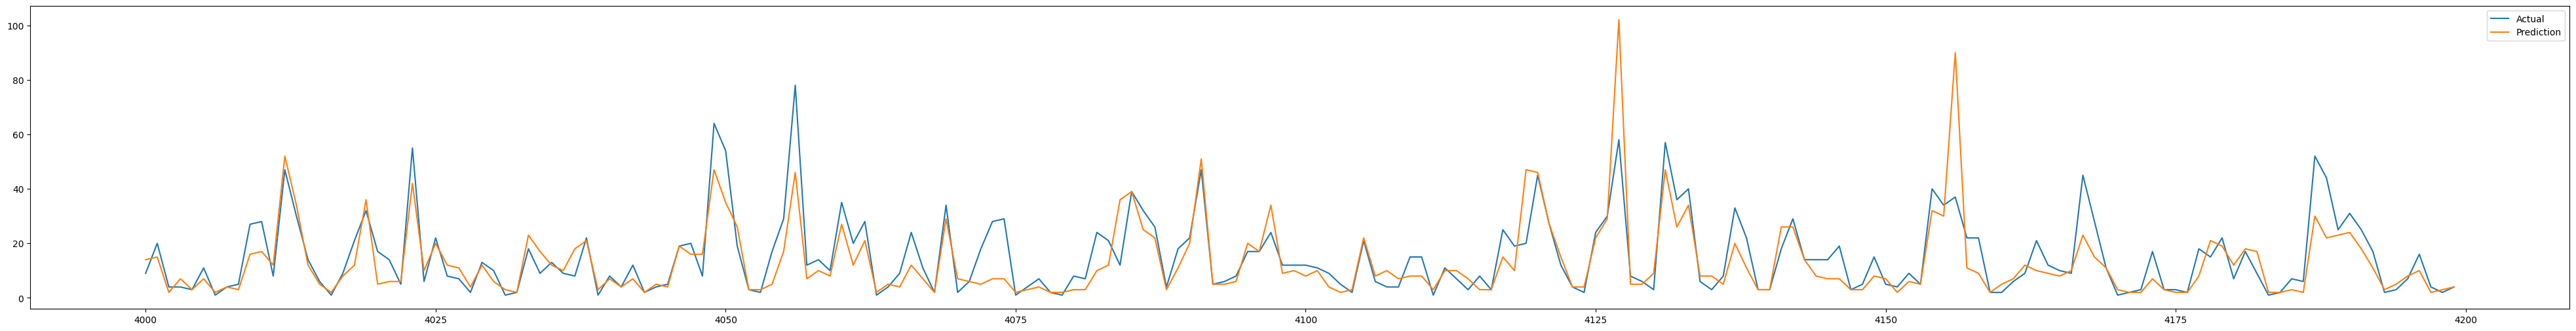

In [23]:
plot_actual_pred(Y_test,rf_test_pred)

# XGB Boost

In [24]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
print(xgb.get_params())
xgb.fit(X_train, np.ravel(Y_train))

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
xgb_train_pred = xgb.predict(X_train)
print("Base XGBoost Regressor Training Evaluation")
evaluate_model(Y_train,xgb_train_pred)

xgb_test_pred = xgb.predict(X_test)
print("Base XGBoost Regressor Testing Evaluation")
evaluate_model(Y_test,xgb_test_pred)

Base XGBoost Regressor Training Evaluation
	R-Squared:  0.8309992173427713
	Mean Absolute Error:  6.09384896000981
	Weighted Absolute Percentage Error:  0.264609331831633
Base XGBoost Regressor Testing Evaluation
	R-Squared:  0.766387850286538
	Mean Absolute Error:  6.653030996363286
	Weighted Absolute Percentage Error:  0.3127275135524633


,Actual,Prediction
0,8,16
1,17,11
2,20,10
3,16,10
4,12,16
...,...,...
83037,1,5
83038,5,3
83039,32,19
83040,30,21


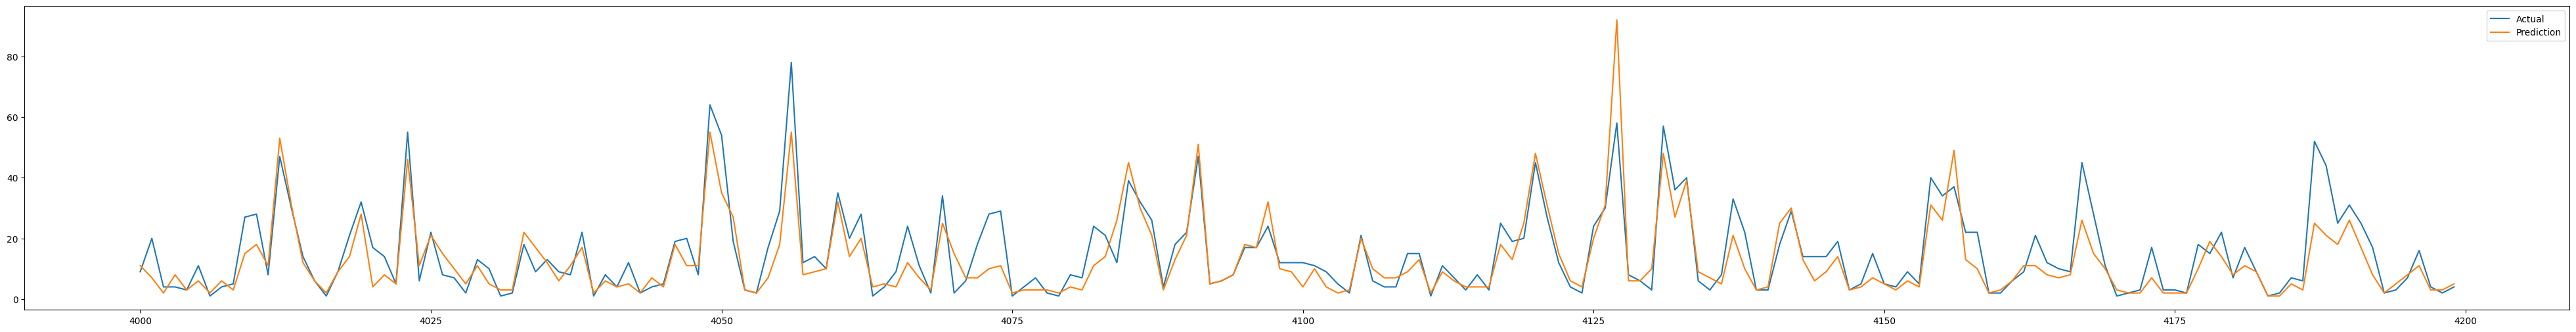

In [26]:
plot_actual_pred(Y_test,xgb_test_pred)

In [35]:
#Save the tuned XGBoostRegressor as the best demand forecasting model
import pickle
with open('best_xgb_2.pkl', 'wb') as file:
    pickle.dump(xgb, file)

# LSTM

### Data Preparation for LSTM

#### Temporal Split for Train Test Data

In [37]:
# Train test data spliting
lstm_train_df = train_df.copy()
lstm_test_df = test_df.copy()
display(lstm_train_df)
display(lstm_test_df)

,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,STORE_ID_COUNT,UPC,UPC_COUNT,UNIT_SALES,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,...,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
0,2009-01-28,2009,5,367,4941,1111009477,11934,7,1.945910,3.178054,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
1,2009-01-28,2009,5,367,4941,1111009497,11960,19,2.944439,2.197225,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
2,2009-01-28,2009,5,367,4941,1111009507,11290,11,2.397895,2.397895,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
3,2009-01-28,2009,5,367,4941,1111038080,10667,5,1.609438,2.944439,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),15TH & MADISON,VALUE,0,24721,0,0,0,1
4,2009-01-28,2009,5,367,4941,1111085319,11959,18,2.890372,2.484907,...,COLD CEREAL,ALL FAMILY CEREAL,15TH & MADISON,VALUE,0,24721,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326200,2011-05-25,2011,21,29159,5529,31254742735,11072,4,1.386294,1.098612,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
326201,2011-05-25,2011,21,29159,5529,31254742835,10465,9,2.197225,1.945910,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
326202,2011-05-25,2011,21,29159,5529,88491201426,10700,22,3.091042,3.332205,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
326203,2011-05-25,2011,21,29159,5529,88491201427,10313,25,3.218876,3.091042,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0


,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,STORE_ID_COUNT,UPC,UPC_COUNT,UNIT_SALES,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,...,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
326205,2011-06-01,2011,22,367,4941,1111009477,11934,8,2.079442,3.091042,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326206,2011-06-01,2011,22,367,4941,1111009497,11960,17,2.833213,1.791759,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326207,2011-06-01,2011,22,367,4941,1111009507,11290,20,2.995732,2.708050,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326208,2011-06-01,2011,22,367,4941,1111085319,11959,16,2.772589,2.944439,...,COLD CEREAL,ALL FAMILY CEREAL,15TH & MADISON,VALUE,0,24721,0,1,0,0
326209,2011-06-01,2011,22,367,4941,1111085345,11980,12,2.484907,2.833213,...,COLD CEREAL,ADULT CEREAL,15TH & MADISON,VALUE,0,24721,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409242,2012-01-04,2012,1,29159,5529,31254742735,11072,1,0.000000,1.098612,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409243,2012-01-04,2012,1,29159,5529,31254742835,10465,5,1.609438,0.693147,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409244,2012-01-04,2012,1,29159,5529,88491201426,10700,32,3.465736,2.944439,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
409245,2012-01-04,2012,1,29159,5529,88491201427,10313,30,3.401197,2.995732,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0


In [38]:
lstm_features = ['YEAR','WEEK_NUM', 'STORE_ID_COUNT','UPC_COUNT','PRICE','FEATURE','DISPLAY',
                 'SEG_VALUE_NAME_ORDINAL','SALES_AREA_SIZE_NUM',
                 'BAG SNACKS','COLD CEREAL','FROZEN PIZZA','ORAL HYGIENE PRODUCTS']
lstm_target = ['UNIT_SALES_LOG']

#### Z-score Standardization

In [39]:
x_scaler = StandardScaler()
lstm_x_train = x_scaler.fit_transform(lstm_train_df[lstm_features])
print("lstm_x_train:", lstm_x_train.shape)

y_scaler = StandardScaler()
lstm_y_train = y_scaler.fit_transform(lstm_train_df[lstm_target])
print("lstm_y_train: ", lstm_y_train.shape)

lstm_x_train: (326205, 13)
lstm_y_train:  (326205, 1)


#### Create Data Sequences

In [40]:
# Create sequences (original order & order by store-product with scaled features/target)

def create_sequences(x_data, y_data, time_steps, len_data):
    X, Y = [], []
    for i in range(time_steps, len_data):
        X.append(x_data[i-time_steps:i])   # [0:2]->[1:3]->[2:4]->[3:5] ...
        Y.append(y_data[i][0])             # [2]->[3]->[4]->[5] ...           
    return np.array(X), np.array(Y)

time_steps = 2
lstm_X_train, lstm_Y_train = create_sequences(lstm_x_train, lstm_y_train, time_steps, len(lstm_train_df))  
print("lstm_X_train: ", lstm_X_train.shape)   
print("lstm_Y_train", lstm_Y_train.shape) 

# Convert data type from float64 to float32
print("\nBefore reshape (lstm_X_train): ", lstm_X_train.dtype)
print("Before reshape (lstm_Y_train): ", lstm_Y_train.dtype)
lstm_X_train = lstm_X_train.astype('float32')
lstm_Y_train = lstm_Y_train.astype('float32')
print("After reshape (lstm_X_train): ", lstm_X_train.dtype)  
print("After reshape (lstm_Y_train): ", lstm_Y_train.dtype)

lstm_X_train:  (326203, 2, 13)
lstm_Y_train (326203,)

Before reshape (lstm_X_train):  float64
Before reshape (lstm_Y_train):  float64
After reshape (lstm_X_train):  float32
After reshape (lstm_Y_train):  float32


In [41]:
lstm_X_train[5:7]

array([[[-1.0925062 , -1.3300098 , -1.7105653 ,  1.0302713 ,
         -0.88918453, -0.32138002, -0.386002  , -1.4676416 ,
         -1.858651  , -0.5222564 ,  1.1891961 , -0.49145392,
         -0.46365887],
        [-1.0925062 , -1.3300098 , -1.7105653 ,  1.0061924 ,
         -0.80767775, -0.32138002, -0.386002  , -1.4676416 ,
         -1.858651  , -0.5222564 ,  1.1891961 , -0.49145392,
         -0.46365887]],

       [[-1.0925062 , -1.3300098 , -1.7105653 ,  1.0061924 ,
         -0.80767775, -0.32138002, -0.386002  , -1.4676416 ,
         -1.858651  , -0.5222564 ,  1.1891961 , -0.49145392,
         -0.46365887],
        [-1.0925062 , -1.3300098 , -1.7105653 ,  0.56002545,
          0.08210441,  3.111581  ,  2.59066   , -1.4676416 ,
         -1.858651  , -0.5222564 , -0.8409042 ,  2.0347788 ,
         -0.46365887]]], dtype=float32)

### LSTM

#### Evaluation Functions

In [42]:
# import tensorflow as tf
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    rss =  K.sum(K.square(y_true - y_pred)) 
    tss = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - rss/(tss + K.epsilon())  # add epsilon to avoid division by zero

def wape(y_true, y_pred):
    APE = K.abs(y_true - y_pred)
    return K.sum(APE) / K.sum(y_true)


In [43]:
def evaluate_lstm_model(y_actual,y_pred):
    y_actual = np.exp(y_actual)
    y_actual = np.round(y_actual).astype(int)

    y_pred = np.exp(y_pred)
    y_pred = np.round(y_pred).astype(int)

    r2 = r2_score(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    ape = np.abs(y_actual - y_pred)
    wape = ape.sum() / y_actual.sum()
   
    print("\tR-Squared: ", r2)
    print("\tMean Absolute Error: ", mae)
    print("\tWeighted Absolute Percentage Error: ", wape)
    return r2, mae, wape


def plot_actual_pred_lstm(y_actual,y_pred):
    y_actual = np.exp(y_actual)
    y_actual = np.round(y_actual).astype(int)
    y_pred = np.exp(y_pred)
    y_pred = np.round(y_pred).astype(int)

    actual_pred_df = pd.DataFrame(y_pred, columns=['Prediction'])
    actual_pred_df = pd.concat([pd.DataFrame(y_actual, columns=['Actual']).reset_index(drop=True), actual_pred_df], axis=1)
    actual_pred_df.rename(columns={actual_pred_df.columns[0]: 'Actual'}, inplace=True)
    display(actual_pred_df)

    plt.figure(figsize=(50, 6))
    plt.plot(actual_pred_df['Actual'][4000:4200], label='Actual')
    plt.plot(actual_pred_df['Prediction'][4000:4200], label='Prediction')
    plt.legend()
    plt.show()

In [44]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def lstm_time_series_cross_validation(model):
    df_cv = df1.copy()
    r2_scores = []
    mae_scores = []
    wape_scores = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df_cv)):
        # time series split
        lstm_train_df = df_cv.iloc[train_idx]
        lstm_test_df = df_cv.iloc[test_idx]
        print("\nFold: {}".format(fold))
        print("\tTrain Indices: ", train_idx)
        print("\tTest Indices: ", test_idx)

        # standardization
        x_scaler = StandardScaler()
        lstm_x_train = x_scaler.fit_transform(lstm_train_df[lstm_features])
        y_scaler = StandardScaler()
        lstm_y_train = y_scaler.fit_transform(lstm_train_df[lstm_target])
        #print("After standardization:", lstm_x_train.shape, lstm_y_train.shape)

        # create sequence
        lstm_X_train, lstm_Y_train = create_sequences(lstm_x_train, lstm_y_train, 2, len(lstm_train_df))  
        print("Train Sequence Data: ", lstm_X_train.shape, lstm_Y_train.shape)   
        lstm_X_train = lstm_X_train.astype('float32')
        lstm_Y_train = lstm_Y_train.astype('float32')

        # fit and train model
        history = model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size= 128)

        # testing
        lstm_train_last2 = lstm_train_df.iloc[-2:]   
        lstm_test_full = pd.concat((lstm_train_last2, lstm_test_df), axis=0)

        lstm_x_test = x_scaler.transform(lstm_test_full[lstm_features])
        lstm_y_test = y_scaler.transform(lstm_test_full[lstm_target])

        lstm_X_test, lstm_Y_test  = create_sequences(lstm_x_test, lstm_y_test, time_steps, len(lstm_test_full)) 
        print("Test Sequence Data: ", lstm_X_test.shape, lstm_Y_test.shape) 
        lstm_X_test = lstm_X_test.astype('float32')
        lstm_Y_test = lstm_Y_test.astype('float32')

        # evaluation
        lstm_test_pred = model.predict(lstm_X_test)
        lstm_test_actual = y_scaler.inverse_transform(lstm_Y_test.reshape(-1, 1))
        lstm_test_pred = y_scaler.inverse_transform(lstm_test_pred) 
        r2, mae, wape = evaluate_lstm_model(lstm_test_actual,lstm_test_pred)

        print(f"\tR²: {r2},  MAE: {mae},  WAPE: {wape}")
        mae_scores.append(mae)
        r2_scores.append(r2)
        wape_scores.append(wape)

    # Calculate the average mean squared error across all folds
    print("\nAverage R-Squared:", np.mean(r2_scores))
    print("Average Mean Absolute Error:", np.mean(mae_scores))
    print("Average Weighted Absolute Percentage Error:", np.mean(wape_scores))

In [45]:
# Define LSTM model architecture
time_steps = lstm_X_train.shape[1]
n_features = lstm_X_train.shape[2]
print("Time steps:", time_steps,  "  Num of Features: ",n_features)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential() 
model.add(Input(shape=(time_steps, n_features)))   # Input layer
model.add(LSTM(units=128, return_sequences=True))  # First layer    
model.add(LSTM(units=64, return_sequences=False))  # Second layer
model.add(Dense(units=1))                          # Output layer 

Time steps: 2   Num of Features:  13



In [46]:
for layer in model.layers:
    print(layer.get_config())

{'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 128, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2}
{'name': 'lstm_1', 'trainable': Tru

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 122177 (477.25 KB)
Trainable params: 122177 (477.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Compile and fit LSTM model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[r_squared])
history = model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size= 128)


Epoch 1/10


2549/2549 [==============================] - 18s 6ms/step - loss: 0.5527 - r_squared: 0.4642
Epoch 2/10
2549/2549 [==============================] - 14s 6ms/step - loss: 0.4925 - r_squared: 0.5684
Epoch 3/10
2549/2549 [==============================] - 14s 5ms/step - loss: 0.4787 - r_squared: 0.5886
Epoch 4/10
2549/2549 [==============================] - 14s 5ms/step - loss: 0.4703 - r_squared: 0.6003
Epoch 5/10
2549/2549 [==============================] - 15s 6ms/step - loss: 0.4632 - r_squared: 0.6099
Epoch 6/10
2549/2549 [==============================] - 14s 6ms/step - loss: 0.4574 - r_squared: 0.6180
Epoch 7/10
2549/2549 [==============================] - 14s 6ms/step - loss: 0.4518 - r_squared: 0.6255
Epoch 8/10
2549/2549 [==============================] - 14s 5ms/step - loss: 0.4467 - r_squared: 0.6321
Epoch 9/10
2549/2549 [==============================] - 14s 6ms/step - loss: 0.4423 - r_squared: 0.6384
Epoch 10/10
2549/2549 [==============================] - 14s 

In [49]:
# Training Evaluation
lstm_train_pred = model.predict(lstm_X_train)

lstm_train_actual = y_scaler.inverse_transform(lstm_Y_train.reshape(-1, 1))
lstm_train_pred = y_scaler.inverse_transform(lstm_train_pred) 

print("Base LSTM Training Evaluation")
evaluate_lstm_model(lstm_train_actual,lstm_train_pred)

10194/10194 [==============================] - 17s 2ms/step
Base LSTM Training Evaluation
	R-Squared:  0.4647766988009092
	Mean Absolute Error:  9.77787757929878
	Weighted Absolute Percentage Error:  0.4245774323257432


(0.4647766988009092, 9.77787757929878, 0.4245774323257432)

In [50]:
# Concatenate last 2 records of training set to create full test set
lstm_train_last2 = lstm_train_df.iloc[-2:]   #-2 means taking the last 2 records of train_df. Depending on time step
lstm_train_last2
lstm_test_full = pd.concat((lstm_train_last2, lstm_test_df), axis=0)
print("lstm_test_full: ", lstm_test_full.shape)
lstm_test_full

lstm_test_full:  (83044, 29)


,WEEK_END_DATE,YEAR,WEEK_NUM,STORE_ID,STORE_ID_COUNT,UPC,UPC_COUNT,UNIT_SALES,UNIT_SALES_LOG,UNIT_SALES_LOG_LAG1,...,CATEGORY,SUB_CATEGORY,STORE_NAME,SEG_VALUE_NAME,SEG_VALUE_NAME_ORDINAL,SALES_AREA_SIZE_NUM,BAG SNACKS,COLD CEREAL,FROZEN PIZZA,ORAL HYGIENE PRODUCTS
326203,2011-05-25,2011,21,29159,5529,88491201427,10313,25,3.218876,3.091042,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
326204,2011-05-25,2011,21,29159,5529,88491212971,10091,8,2.079442,1.098612,...,COLD CEREAL,KIDS CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
326205,2011-06-01,2011,22,367,4941,1111009477,11934,8,2.079442,3.091042,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326206,2011-06-01,2011,22,367,4941,1111009497,11960,17,2.833213,1.791759,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
326207,2011-06-01,2011,22,367,4941,1111009507,11290,20,2.995732,2.708050,...,BAG SNACKS,PRETZELS,15TH & MADISON,VALUE,0,24721,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409242,2012-01-04,2012,1,29159,5529,31254742735,11072,1,0.000000,1.098612,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409243,2012-01-04,2012,1,29159,5529,31254742835,10465,5,1.609438,0.693147,...,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),CARROLLTON,MAINSTREAM,1,54927,0,0,0,1
409244,2012-01-04,2012,1,29159,5529,88491201426,10700,32,3.465736,2.944439,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0
409245,2012-01-04,2012,1,29159,5529,88491201427,10313,30,3.401197,2.995732,...,COLD CEREAL,ADULT CEREAL,CARROLLTON,MAINSTREAM,1,54927,0,1,0,0


In [51]:
# Z-Score Standardization of Test Set
lstm_x_test = x_scaler.transform(lstm_test_full[lstm_features])
print("lstm_x_test: ", lstm_x_test.shape)

lstm_y_test = y_scaler.transform(lstm_test_full[lstm_target])
print("lstm_y_test: ", lstm_y_test.shape)

lstm_x_test:  (83044, 13)
lstm_y_test:  (83044, 1)


In [52]:
# Create Sequence for Test Set
time_steps = 2
lstm_X_test, lstm_Y_test  = create_sequences(lstm_x_test, lstm_y_test, time_steps, len(lstm_test_full)) 

print("lstm_X_test: ", lstm_X_test.shape)  
print("lstm_Y_test: ", lstm_Y_test.shape) 

print("\nBefore reshape (lstm_X_test): ", lstm_X_test.dtype)
print("Before reshape (lstm_Y_test): ", lstm_Y_test.dtype)
lstm_X_test = lstm_X_test.astype('float32')
lstm_Y_test = lstm_Y_test.astype('float32')
print("After reshape (lstm_X_test): ", lstm_X_test.dtype)
print("After reshape (lstm_Y_test): ", lstm_Y_test.dtype)

lstm_X_test:  (83042, 2, 13)
lstm_Y_test:  (83042,)

Before reshape (lstm_X_test):  float64
Before reshape (lstm_Y_test):  float64
After reshape (lstm_X_test):  float32
After reshape (lstm_Y_test):  float32


In [53]:
lstm_test_pred = model.predict(lstm_X_test)

lstm_test_actual = y_scaler.inverse_transform(lstm_Y_test.reshape(-1, 1))
lstm_test_pred = y_scaler.inverse_transform(lstm_test_pred) 

print("Base LSTM Testing Evaluation")
evaluate_lstm_model(lstm_test_actual,lstm_test_pred)

2596/2596 [==============================] - 5s 2ms/step
Base LSTM Testing Evaluation
	R-Squared:  0.35347110633812173
	Mean Absolute Error:  10.923231617735604
	Weighted Absolute Percentage Error:  0.5134494436655076


(0.35347110633812173, 10.923231617735604, 0.5134494436655076)